In [2]:
import sys
import os
sys.path.append(os.path.abspath('../datasets'))

In [ ]:
import torch.nn as nn
import wandb
import torch
import pickle
from dataset import SolarFlaresData
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
from typing import Any
from datetime import datetime
import drms
import pandas as pd
import torchvision.transforms as T
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [4]:
def read_df_from_pickle(path):
    with open(path, "rb") as f:
        df = pickle.load(f)
    return df

# Problem Statement

We're exploring a challenge of predicting solar flares. Given the line-of-sight magnetic images (magnetograms), this task involves telling apart active regions that are about to experience a strong solar flare (either M- or X-class) in the next 24 hours (based on the input magnetogram) from regions that are expected to remain calm without any flares during the same period.







# Dataset

Our dataset can be mathematically described as follows
$$ \ \text{Dataset:} \quad \{(X_i, Y_i) \mid X_i \in \mathbb{R}^{128 \times 128}, Y_i \in \{0, 1\}\} \$$

Our dataset consists of pairs $(X_i, Y_i)$ where $X_i$ represents a 128×128 magnetogram image and $Y_i$ is either 0 or 1, indicating the absence or presence of a solar flare with intensity greater than or equal to M1 in the next 24 hours time period.

#### Magnetograms Preprocesssing

To preprocess the magnetograms we use the following approach : 

1. Check for NaN Values:

    - Examine each magnetogram for the presence of NaN (Not a Number) values.

2. Handle NaN Values:

    - If NaN values are found, decide on a strategy:
        - Exclude the magnetogram from further processing.
        
3. Apply Z-score Standardization:

    - Standardize each magnetogram using Z-score normalization.
    - Compute the mean ($\mu$) and standard deviation ($\sigma$) of the pixel values across all magnetograms.
    - For each pixel value $x$ in a magnetogram, calculate the Z-score using the formula: $$\Z = \frac{{X - \mu}}{{\sigma}}$$
    - This ensures that pixel values are centered around zero and scaled by the standard deviation.
4. Reshape the magnetogram: 
- active regions magnetograms have different sizes; that is why we need to reshape them to have similar dimensions. 
In this work,we reshape the magnetograms to 128 x 128. 
5. Output Preprocessed Magnetograms:

    The result of these preprocessing steps is a set of magnetograms ready for use in our CNN model.

The diagram below illustrates the magnetogram preprocessing steps

![alternative text](../figures/magnetogram_preprocessing.png)

In [5]:
dataset = read_df_from_pickle("../data/SHARP/SHARP.pkl")

A sample SHARP Acttive Region before Preprocessing

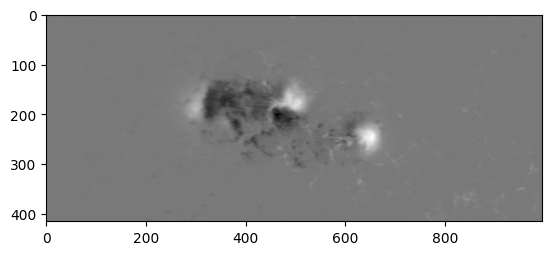

In [6]:
plt.imshow(dataset[dataset["T_REC"] == "2015-12-23 01:12:00"]["magnetogram"][0], cmap="gray")
plt.show()

SHARP Active Region after Preprocessing 

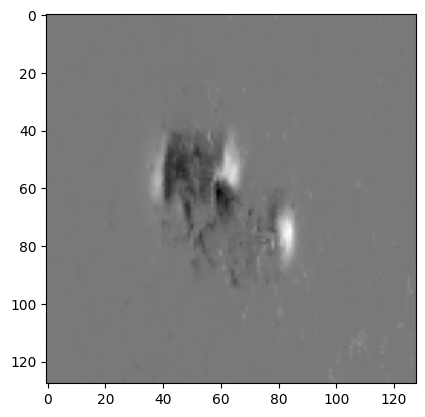

In [7]:
transform = T.Resize((128, 128))
magnetogram = dataset[dataset["T_REC"] == "2015-12-23 01:12:00"]["magnetogram"][0]
# print(magnetogram.shape)
resized_magnetogram = transform(torch.from_numpy(magnetogram).unsqueeze(0))

plt.imshow(resized_magnetogram.squeeze(0), cmap="gray")
plt.show()

#### Labelling Process

The methodology employed for labeling draws upon the approach previously established by Sun et al. For further details, refer to  [Sun et al. ](https://arxiv.org/pdf/2204.03710.pdf)


1. **Observation and Prediction Periods:**

   Define a sliding window with a 24-hour observation period and a subsequent 24-hour prediction period, and step size of 96 minutes. Observe the magnetogram at the end of the observation period.

2. **Maximum Flare Class Observation:**

   For each sliding window step, determine the maximum solar flare class (e.g., B, C, M, X) that occurs within both the observation period and the prediction period.

3. **Label Assignment:**

   - **Positive Label:**
   
     If there is a strong flare (≥ M-class) in the prediction period, regardless of the observation period's activity, label the magnetogram observed at the end of the observation period as positive.

     ![alternative text](../figures/labelling_weak_strong.png)

     ![alternative text](../figures/magnetogram_labelling_process_noflare_strong.png)

   - **Negative Label:**
   
     If there is no flare activity spotted in both the observation and the prediction period, label the magnetogram as negative.

      ![alternative text](../figures/magnetogram_labelling_process_noflare_noflare.png)

   - **Exclusion:**
   
     To enhance the contrast between the positive and negative classes, exclude the observed magnetogram from the dataset if:
     
     - There is flare activity degradation (maximum flare intensity in the prediction period is less than in the observation period).
     - Weak flares (less than M-class) are observed in the prediction period only.

      ![alternative text](../figures/magnetogram_labelling_process_strong_noflare.png)

| Observation Period \ Prediction Period | No Flare                        | Weak Flare (<M-class)          | Strong Flare (>= M-class)      |
|----------------------------------------|---------------------------------|--------------------------------|--------------------------------|
| No Flare                               | Negative                        | Weak flaring event (excluded)          | Positive                       |
| Weak Flare (<M-class)                  | Flare Degradation (excluded)    | Weak flaring event (excluded)          | Positive                       |
| Strong Flare (>= M-class)              | Flare Degradation (excluded)    | Flare Degradation (excluded)   | Positive                       |


In [8]:
dataset.head()

,T_REC,region_type,region_no,NOAA_ARS,params,magnetogram,label
0,2015-12-23 01:12:00,harp,6206,12473,"[-0.0100475028260637, 1.2602700352173024, 0.99...","[[-0.06619508896585617, -0.05401688210435899, ...",1
1,2015-12-23 02:48:00,harp,6206,12473,"[0.066513399626304, 1.2994691822566444, 1.0664...","[[-0.22045237587815394, -0.204214766729491, -0...",1
2,2015-12-23 04:24:00,harp,6206,12473,"[0.1669003090659236, 1.328868542536151, 1.1183...","[[-0.032705020096738896, -0.041838675242861785...",1
3,2015-12-23 06:00:00,harp,6206,12473,"[0.2331366084904823, 1.2643052415301756, 1.161...","[[-0.08040299697093622, -0.043868376386444655,...",1
4,2015-12-23 07:36:00,harp,6206,12473,"[0.2683990988316146, 1.29255168572029, 1.14740...","[[-0.10881881298109633, -0.13013067498871642, ...",1


In [9]:
class SolarFlaresData(Dataset):
    def __init__(self, df, random_undersample=True):
        self.resize_transform = T.Resize((128, 128))
        self.df = self.random_undersample(df) if random_undersample else df

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.df.loc[idx, "params"]).to(torch.float32),
            self.resize_transform(
                torch.from_numpy(self.df.loc[idx, "magnetogram"])
                .unsqueeze(0)
                .to(torch.float32)
            ),
            torch.tensor(self.df.loc[idx, "label"], dtype=torch.float32).reshape(
                1,
            ),
        )

    def random_undersample(self, df):
        positive_samples_count = len(df[df.label == 1])
        negative_samples_count = len(df[df.label == 0])
        samples_dropped_count = negative_samples_count - positive_samples_count
        indices_to_drop = np.random.choice(
            df[df.label == 0].index, samples_dropped_count, replace=False
        )
        df_dropped = df.drop(indices_to_drop)
        return df_dropped.reset_index()

    def __len__(self):
        return self.df.shape[0]

# Model

Convolutional Neural Networks (CNNs) are powerful tools in image analysis. When applied to predicting solar flares from magnetogram images, they shine because they're adept at automatically learning and recognizing complex patterns in the images. The spatial structures and hierarchies in magnetogram images align well with CNNs, making them an excellent choice for detecting subtle features that may indicate impending solar flare activity. The CNN model is employed on the line-of-sight magnetogram. The optimization process is facilitated by the Adam optimizer, which seeks to minimize a binary cross-entropy loss function. Focal Loss is also experimented.

![alternative text](../figures/cnn_arch.png)

![alternative text](../figures/cnn_archdrawio.png)

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.ModuleList(
            [cnn_block(11, 1), cnn_block(11, 64)]
            + [cnn_block(3, 64), cnn_block(3, 64), cnn_block(3, 64)]
        )
        self.linear = nn.Linear(64, 128)
        self.bn = nn.BatchNorm1d(128)
        self.drop_out = nn.Dropout(0.5)
        self.linear2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.drop_out2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(64, 1)

    def forward(self, x):
        for idx, l in enumerate(self.cnn):
            x = l(x)
            
        x = x.squeeze(2).squeeze(2).reshape(-1, 64)
        
        x = self.linear(x)
        x = self.bn(x)
        x = self.drop_out(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.drop_out2(x)
        x = self.linear3(x)
        return x


class cnn_block(nn.Module):
    def __init__(self, filter_size, in_channels):
        super().__init__()
        self.cnn = nn.Conv2d(
            in_channels=in_channels, out_channels=64, kernel_size=filter_size
        )
        self.bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.cnn(x)
        x = self.bn(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        return x



# Training

In response to the pervasive challenge of class imbalance within predictive modeling, this study introduces a novel loss function, ingeniously designed to mitigate this issue. The proposed loss function is elegantly defined as a weighted summation of the Binary Cross-Entropy Loss  and Focal Loss , thereby harnessing the strengths of both in a single, cohesive formulation. Specifically, the composite loss function, \(L(y, p)\), is articulated as follows:

$$
L(y, p) = \lambda L_{BCE}(y, p) + (1 - \lambda)L_{FL}(y, p)
$$

where ($\lambda$) serves as a balancing parameter, delicately adjusting the contribution of each component loss to the overall function. 


In [17]:
class FocalBCELoss(nn.Module):
    """
    Combination of BCE and Focal Loss
    """

    def __init__(self, alpha=1, gamma=2, weight=None, reduction="mean"):
        super(FocalBCELoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, x, target):
        # Binary Cross Entropy Loss
        bce_loss = F.binary_cross_entropy_with_logits(x, target)

        # Compute the focal loss term
        p_t = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma + bce_loss

        # Combine both losses
        loss = focal_loss

        # if self.reduction == "mean":
        #     loss = torch.mean(loss)
        # elif self.reduction == "sum":
        #     loss = torch.sum(loss)

        return loss


In [18]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
    disp.plot()
    plt.show()

In [19]:
def read_df_from_pickle(path):
    with open(path, "rb") as f:
        df = pickle.load(f)
    return df


def compute_accuracy(predictions, correct):
    return (predictions == correct).sum().item() / predictions.shape[0]


def confusion(prediction, target):
    confusion_vector = prediction / target
    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float("inf")).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives


def compute_tss(prediction, target):
    TP, FP, TN, FN = confusion(prediction, target)
    # print(TP, FP, TN, FN)
    N = TN + FP
    P = TP + FN
    return TP / P - FP / N


def predict(test_loader, model):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
            for _, data, target in tepoch:
                #tepoch.set_description(f"Epoch {epoch}")
                data, target = data.to(device), target.to(device)
                logits = model(data)
                predictions = logits.argmax(dim=1, keepdim=True).squeeze()
                all_predictions.extend(predictions.tolist())
                all_targets.extend(target.tolist())
    return all_predictions, all_targets


def region_based_split(dataset_df, train_regions, test_regions):
    train_df = dataset_df[dataset_df.region_no.isin(set(train_regions))]
    test_df = dataset_df[dataset_df.region_no.isin(set(test_regions))]
    return train_df, test_df


# Hyperparameters
lr = 0.001
batch_size = 16
num_epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
df = read_df_from_pickle("../data/SHARP/SHARP.pkl")
train_df, test_df = region_based_split(
    df, train_regions=[1, 6206, 4097, 10, 7169], test_regions=[2, 6327]
)
print(f"regions in train set {train_df.region_no.unique()}")
print(f"regions in test set{test_df.region_no.unique()}")

train_dataset = SolarFlaresData(train_df.reset_index(), random_undersample=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SolarFlaresData(test_df.reset_index(), random_undersample=False)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
model = CNN()
optimizer = Adam(model.parameters(), lr=lr)

regions in train set [6206 10 7169 4097 1]
regions in test set[6327 2]


In [20]:
criterion = FocalBCELoss()

Epoch 19: 100%|██████████| 7/7 [00:02<00:00,  3.39batch/s, valid_loss=0.819] 


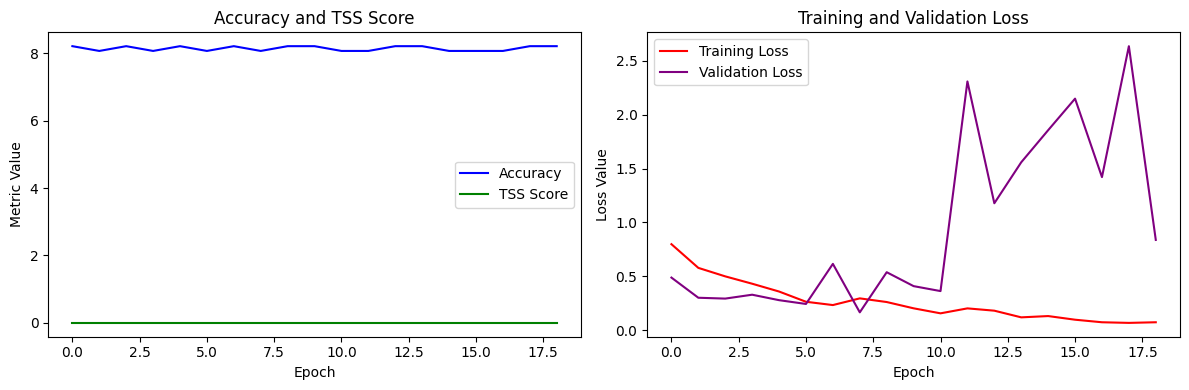

Experiment summary
Number of epochs 20
batch size 16
train set length 351 with 39 positive examples and 312 negative examples
test set length 113 with 55 positive examples and 58 negative examples
max accuracy 8.212389380530974
max tss score 0.0


In [21]:

train_losses = []
val_losses = []
accuracies = []
tss_scores = []
for epoch in range(1, num_epochs):
    model.train()
    epoch_train_losses = []
    with tqdm(train_loader, unit="batch") as tepoch:
        for _, data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            logits = model(data)
            predictions = logits.argmax(dim=1, keepdim=True).squeeze()
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())
            # acc = compute_accuracy(predictions, target)
            # tss = compute_tss(acc)
            tepoch.set_postfix(loss=loss.item())
    with torch.no_grad():
        model.eval()
        with tqdm(test_loader, unit="batch") as tepoch:
            batch_correct = []
            batch_tss = []
            batch_valid_losses = []
            all_predictions = []
            all_targets = []
            for _, data, target in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                data, target = data.to(device), target.to(device)
                logits = model(data)
                predictions = logits.argmax(dim=1, keepdim=True).squeeze()
                all_predictions.append(predictions)
                all_targets.append(target)
                loss = criterion(logits, target)
                batch_valid_losses.append(loss.item())
                correct = (predictions == target).sum().item()
                batch_acc = compute_accuracy(predictions, target)
                batch_correct.append(correct)

                tepoch.set_postfix(
                    valid_loss=loss.item(),
                )
    train_losses.append(np.mean(epoch_train_losses))
    val_losses.append(np.mean(batch_valid_losses))
    accuracies.append(np.sum(batch_correct) / len(test_dataset))
    all_predictions = torch.cat(all_predictions, axis=0)
    all_targets = torch.cat(all_targets, axis=0)
    # print(all_targets.shape, all_predictions.shape)
    tss_scores.append(compute_tss(all_predictions, all_targets))
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(len(accuracies)), accuracies, label="Accuracy", color="blue")
plt.plot(range(len(tss_scores)), tss_scores, label="TSS Score", color="green")
plt.title("Accuracy and TSS Score")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(len(train_losses)), train_losses, label="Training Loss", color="red")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss", color="purple")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.tight_layout()
plt.show()

print("Experiment summary")
print(f"Number of epochs {num_epochs}")
print(f"batch size {batch_size}")
print(
    f"train set length {len(train_df)} with {len(train_df[train_df.label == 1])} positive examples and {len(train_df[train_df.label == 0])} negative examples"
)

print(
    f"test set length {len(test_df)} with {len(test_df[test_df.label == 1])} positive examples and {len(test_df[test_df.label == 0])} negative examples"
)
print(f"max accuracy {max(accuracies)}")
print(f"max tss score {max(tss_scores)}")
